### Info

3D U-Net trained on FeTA2021 with Uniform Patch Sampler and Grid Patch Sampler.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchio as tio
import torchvision.transforms as transforms

from data.Dataset import *
from data.transforms import *
from models import Evaluator3D, models
from models.Predictor import Predictor
from utils.LossFunctions import DC_and_CE_loss, GDiceLossV2
from utils.Utils import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_path = "../../data/processed/lucas/"

# Transformations.
transform_eval = None

# Split dataset.
lucas_val = MRIDataset(FeTABalancedDistribution, "val", dataset_path, transform=transform_eval)
lucas_test = MRIDataset(FeTABalancedDistribution, "test", dataset_path, transform=transform_eval)

torch.manual_seed(0)
lucas_val_loader = torch.utils.data.DataLoader(dataset=lucas_val, batch_size=1)
lucas_test_loader = torch.utils.data.DataLoader(dataset=lucas_test, batch_size=1)

lucas_val.meta_data = lucas_val.meta_data.drop(columns=['Unnamed: 3'])
lucas_test.meta_data = lucas_test.meta_data.drop(columns=['Unnamed: 3'])

In [3]:
criterion = DC_and_CE_loss({'batch_dice': True, 'smooth': 1e-5, 'do_bg': False, 'square': False}, {})

### Warning! 
Tensorboard event files contains validation scores, not test scores.

### GridPatchSampler

In [4]:
path_events_file = '../../models/20230105/GridSampler/events.out.tfevents.1672949016.DESKTOP-BN0TMAF.4216.0'
results = read_scalars(path_events_file, -1)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Epoch:  40


In [5]:
unet3d = models.UNet3D().to(device)
unet3d.load_state_dict(torch.load("../../models/20230105/GridSampler/weights/39_model.pth"))

predictor = Predictor(unet3d, (128, 128, 128))
sub = lucas_val[0]

Validation : 100%|██████████| 10/10 [00:41<00:00,  4.16s/it, Loss: -0.8391]


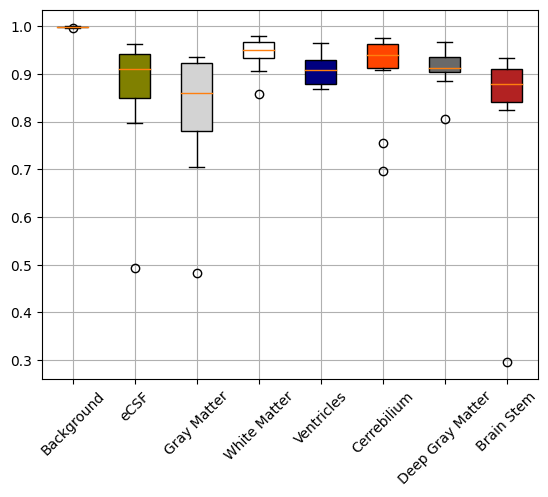

,0,1,2,3,4,5,6,7
0,0.998109,0.862596,0.820167,0.941437,0.909285,0.902479,0.910965,0.824091


In [6]:
evaluator = Evaluator3D(criterion, unet3d, (128, 128, 128), lucas_val_loader)
_, scores = evaluator.evaluate()
avg_scores = print_evaluation_results(scores, lucas_val)
pd.DataFrame(avg_scores).T

Validation : 100%|██████████| 10/10 [00:51<00:00,  5.16s/it]


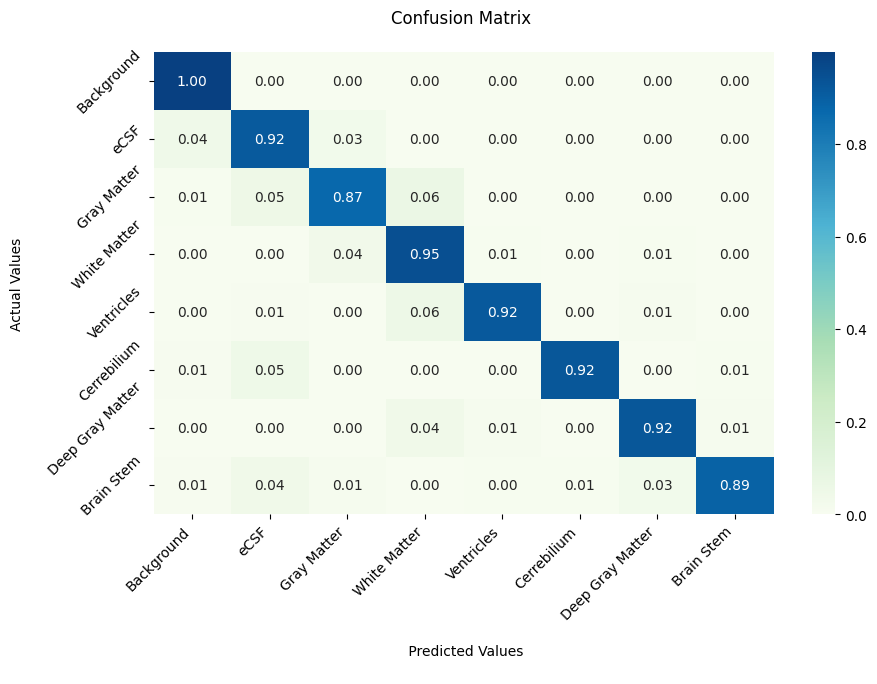

In [7]:
evaluator.calculate_cm()
evaluator.plot_confusion_matrix()

Validation : 100%|██████████| 10/10 [00:40<00:00,  4.02s/it, Loss: -0.8175]


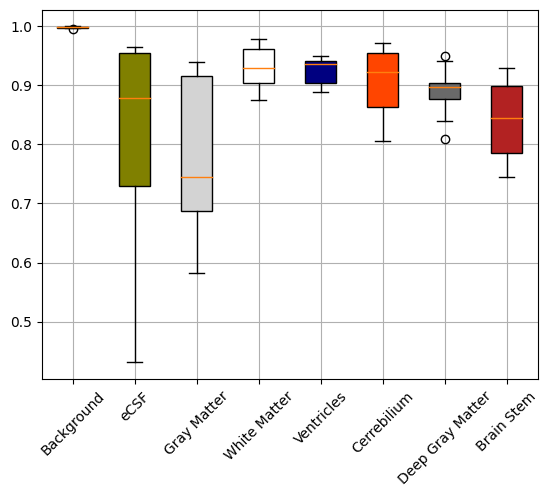

,0,1,2,3,4,5,6,7
0,0.997998,0.807299,0.777723,0.929371,0.924937,0.906429,0.890801,0.839757


In [8]:
tester = Evaluator3D(criterion, unet3d, (128, 128, 128), lucas_test_loader)
_, scores = tester.evaluate()
avg_scores = print_evaluation_results(scores, lucas_test)
pd.DataFrame(avg_scores).T

Validation : 100%|██████████| 10/10 [00:52<00:00,  5.24s/it]


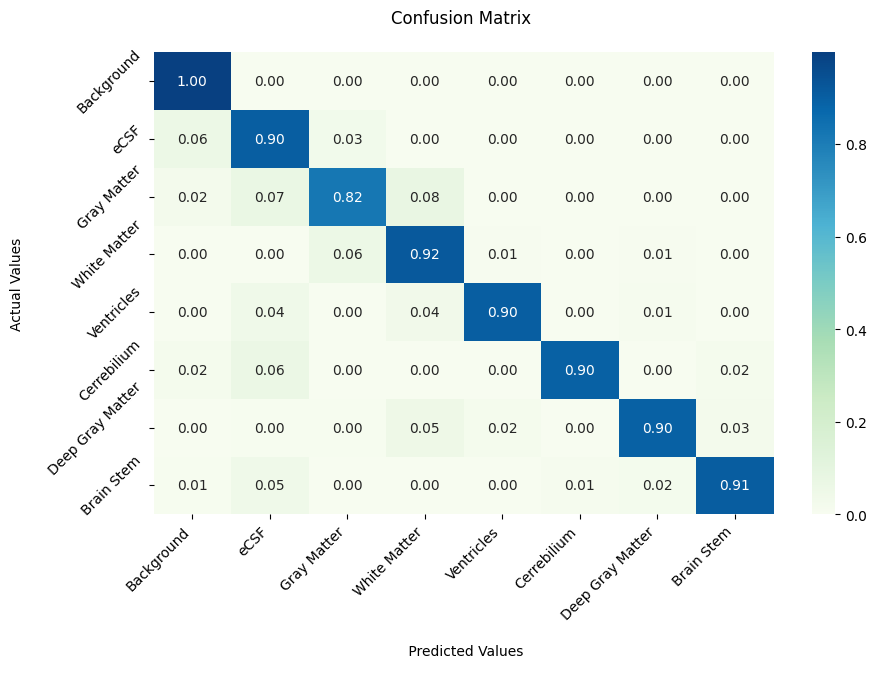

In [9]:
tester.calculate_cm()
tester.plot_confusion_matrix()

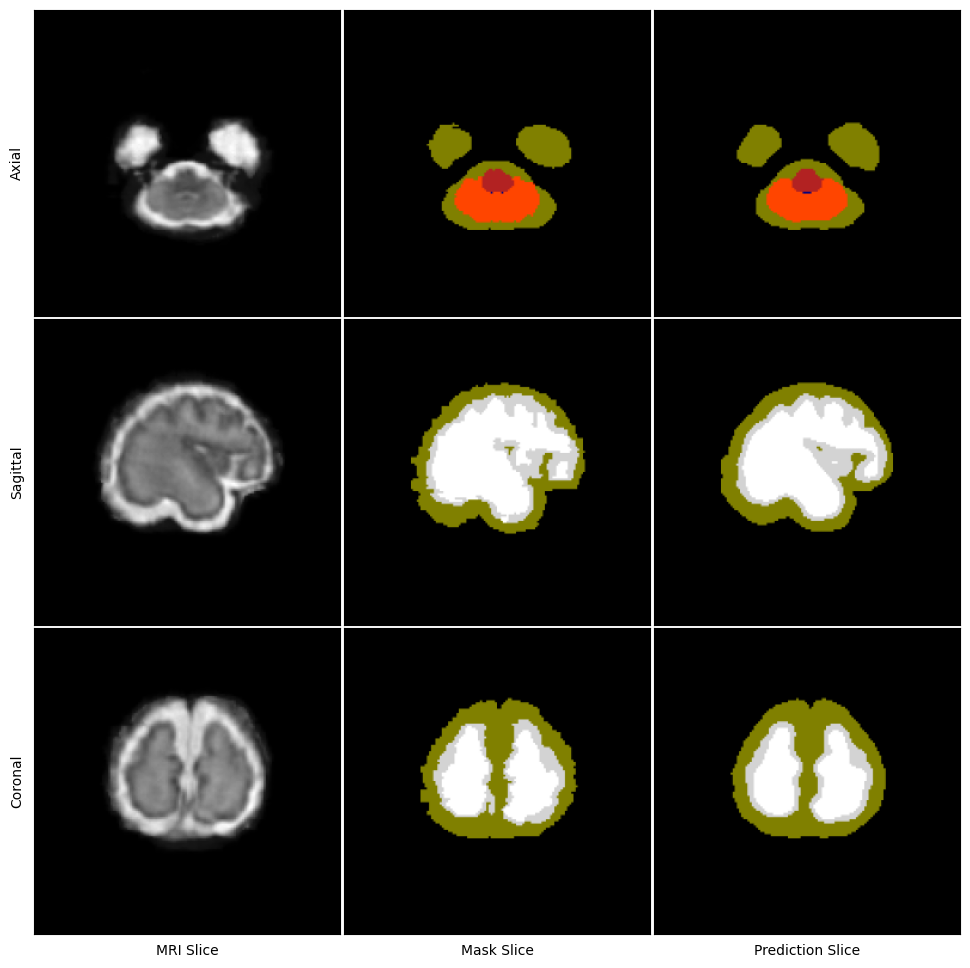

In [10]:
prediction = predictor.predict(lucas_val[0])
pred_mask = torch.argmax(prediction, dim=1)
slice_idx = 45

plot_sub_orient(sub.mri.data, sub.mask.data, pred_mask, slice_idx)

### UniformSampler

In [11]:
path_events_file = '../../models/20230103/FeTABalanced_lucas/events.out.tfevents.1672826536.DESKTOP-BN0TMAF.9864.0'
results = read_scalars(path_events_file, -1)

Epoch:  20


In [12]:
unet3d.load_state_dict(torch.load("../../models/20230103/FeTABalanced_lucas/weights/19_model.pth"))
predictor = Predictor(unet3d, (128, 128, 128))
sub = lucas_val[0]

Validation : 100%|██████████| 10/10 [00:40<00:00,  4.03s/it, Loss: -0.8424]


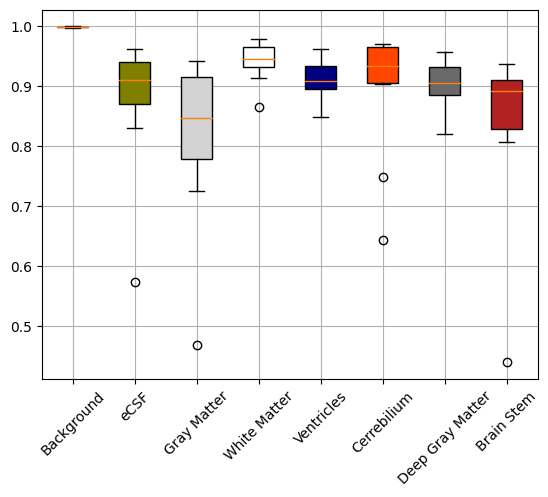

,0,1,2,3,4,5,6,7
0,0.998264,0.875479,0.816296,0.941387,0.912247,0.893473,0.904006,0.838066


In [13]:
evaluator = Evaluator3D(criterion, unet3d, (128, 128, 128), lucas_val_loader)
_, scores = evaluator.evaluate()
avg_scores = print_evaluation_results(scores, lucas_val)
pd.DataFrame(avg_scores).T

Validation : 100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


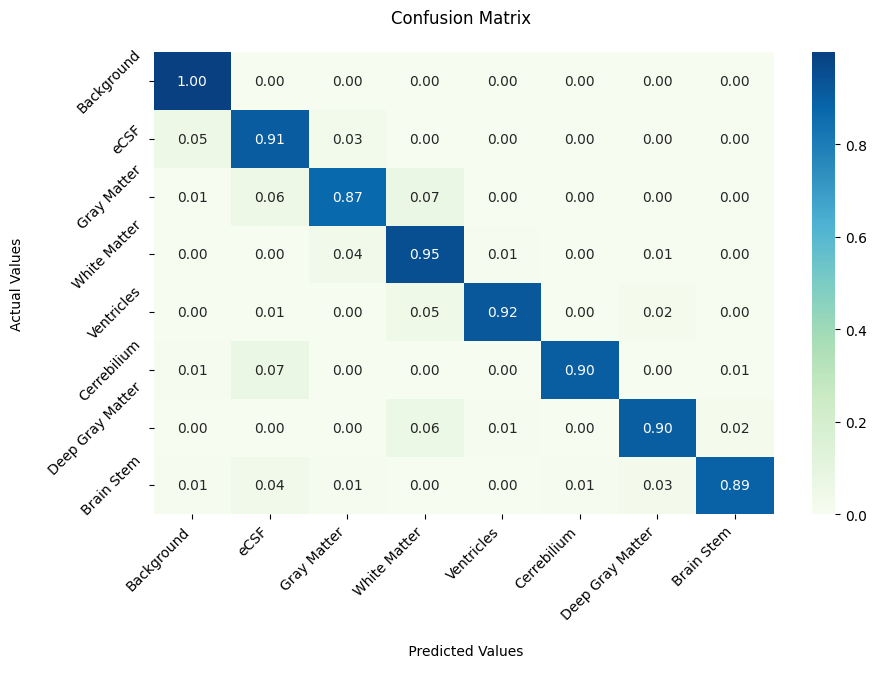

In [14]:
evaluator.calculate_cm()
evaluator.plot_confusion_matrix()

Validation : 100%|██████████| 10/10 [00:40<00:00,  4.05s/it, Loss: -0.8196]


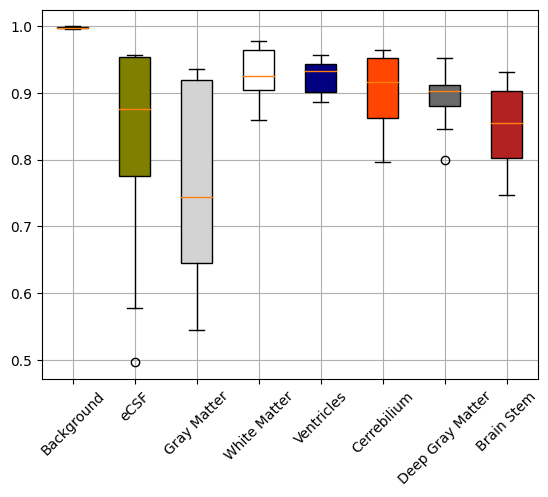

,0,1,2,3,4,5,6,7
0,0.997932,0.824551,0.764364,0.927237,0.923775,0.903206,0.894308,0.85018


In [15]:
tester = Evaluator3D(criterion, unet3d, (128, 128, 128), lucas_test_loader)
_, scores = tester.evaluate()
avg_scores = print_evaluation_results(scores, lucas_test)
pd.DataFrame(avg_scores).T

Validation : 100%|██████████| 10/10 [00:52<00:00,  5.22s/it]


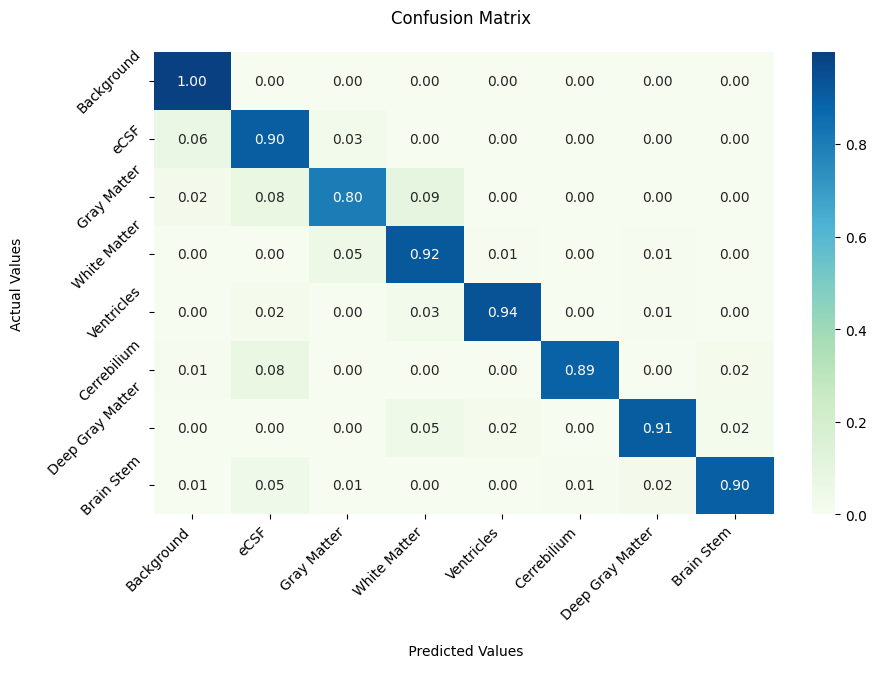

In [16]:
tester.calculate_cm()
tester.plot_confusion_matrix()

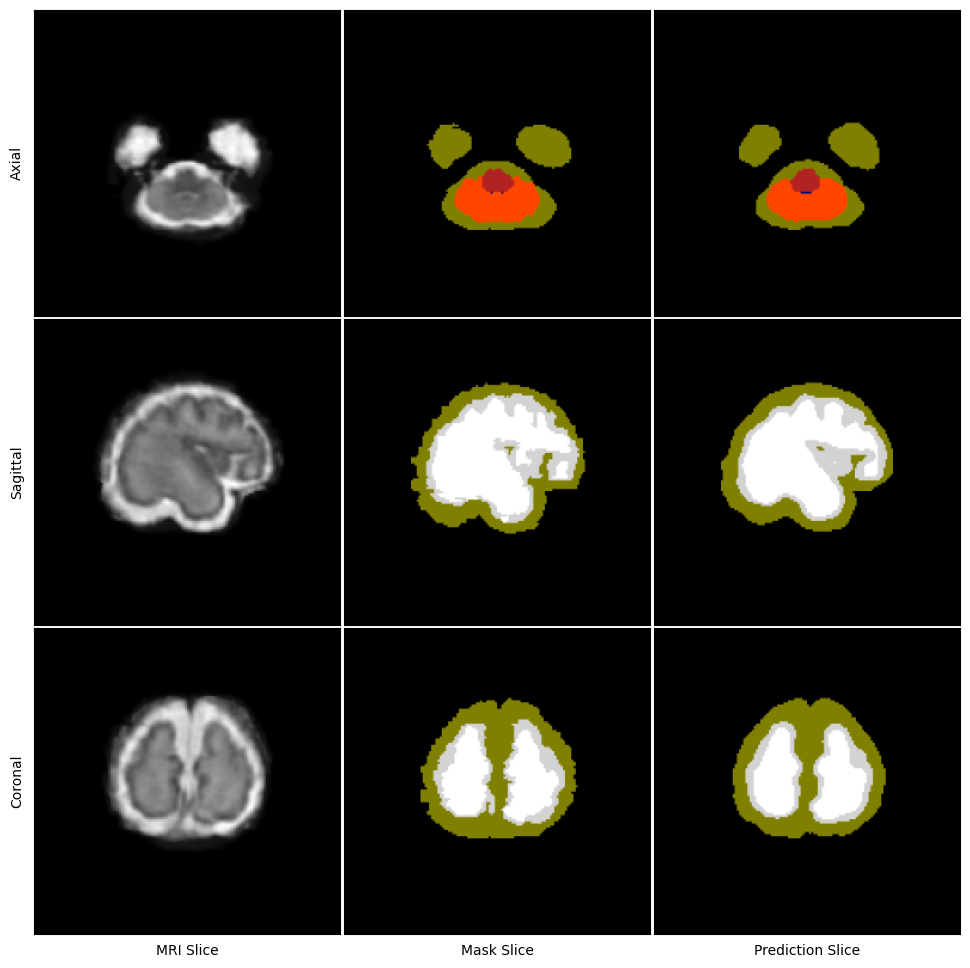

In [17]:
prediction = predictor.predict(lucas_val[0])
pred_mask = torch.argmax(prediction, dim=1)
slice_idx = 45

plot_sub_orient(sub.mri.data, sub.mask.data, pred_mask, slice_idx)